Import some standard libraries.

In [1]:
## Solution by Muhammad Emzir, Aalto University, Oct 2020
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
sns.set()

Declare some variables
Depending on how you define the initial state and how big the measurement noises are, you might end up in a solution that is quite far from the truth.
Here, we use a fairly small noise variances. Change the noise variance $\sigma$

In [2]:
#set some variables

N = 10 # number of observation set

sigma = 1# we use the same standard deviation for all measurement

alpha = 100. #set alpha

X_max = 30
Y_max = 30

x = np.array([0.5*X_max,0.5*Y_max]) #set the true variable

x_0 = np.array([1,1]) #set the initial guess

iteration_end = 10 #how many iteration

x_history_GN = np.zeros((iteration_end,2)) #the evolution of estimation results recorded here

x_history_GN[0,:] = x_0 # you know this right?

x_history_GN_LS = x_history_GN.copy() #for Gauss Newton Line Search

x_history_LM = x_history_GN.copy() #for Levenberg Marquardt

I = np.eye(2)

R = sigma*sigma*I # measurement variance

R_inv = I/(sigma*sigma) #cache the inverse

E = sigma*I #we will use this below

E_inv = (1/sigma)*I

N_gamma_grid = 1000 #Grid search for gamma

Define the nonlinear measurmeent function $\mathbf g(\mathbf{x})$ and its Jacobian $\mathbf G(\mathbf{x})$

In [3]:
def g(x):
    return alpha*np.sqrt(x)

In [4]:
def G(x):
    return (alpha/2)*np.diag(1/np.sqrt(x))

Define the cost function $J$

In [14]:
def J_cost(y,x):
    #This relies on the fact that our R is diagonal, otherwise you need to use different notation
    g_ = g(x)
    e = (y-g_)@E_inv #<-- the previous exercise contain error here
    return np.sum(e**2)

Simulate the measurements

In [15]:
r = sigma*np.random.randn(N,2)
print('r ',np.shape(r))
print('g(x) ',np.shape(g(x)))

y = g(x)+ r
print('y ',np.shape(y))

Grid_size=100
[x_grid,y_grid] = np.meshgrid(np.arange(Grid_size)*X_max/Grid_size,np.arange(Grid_size)*Y_max/Grid_size)
J = np.zeros((Grid_size,Grid_size))
for i in range(x_grid.shape[0]):
    for j in range(x_grid.shape[1]):
        J[i,j] = J_cost(y,np.array([x_grid[i,j],y_grid[i,j]]))

r  (10, 2)
g(x)  (2,)
y  (10, 2)


We use a trick that in the case that $\mathbf{r}_i$ is independent each other we have
$$
(\bar{\mathbf{G}}^\top \bar{\mathbf{R}}^{-1} \bar{\mathbf{G}}    )^{-1}\bar{\mathbf{G}}^\top \bar{\mathbf{R}}^{-1}(\mathbf{y} - \bar{\mathbf{g}}(\mathbf{x}))
= (\sum_i\mathbf{G}^\top \mathbf R^{-1} \mathbf G    )^{-1}\sum_i\mathbf{G}^\top \mathbf{R}^{-1}(\mathbf{y}_i - \mathbf{g}(\mathbf{x}))
$$
Which equals to
$$
(\mathbf{G}^\top \mathbf R^{-1} \mathbf{G})^{-1}\dfrac{1}{N}\sum_i\mathbf{G}^\top \mathbf{R}^{-1}(\mathbf{y}_i - \mathbf{g}_i(\mathbf{x}))
$$

In [7]:
#Routine for Gauss Netwon
for j in range(iteration_end-1):
    gj = g(x_history_GN[j,:])
    Gj = G(x_history_GN[j,:])
    x_history_GN[j+1,:] = x_history_GN[j,:] + np.linalg.solve((Gj.T@R_inv@Gj),Gj.T@R_inv@np.sum(y-gj,axis=0)/N)



In [8]:
#Routine for Gauss Netwon with Line Search
gamma_max = 50
gamma = np.arange(1,N_gamma_grid+1)*gamma_max/N_gamma_grid
for j in range(iteration_end-1):
    x_now = x_history_GN_LS[j,:]
    gj = g(x_now)
    Gj = G(x_now)
    Delta_x = np.linalg.solve((Gj.T@R_inv@Gj),Gj.T@R_inv@np.sum(y-gj,axis=0)/N)
    J_min = J_cost(y,x_now)
    gamma_min = 0
    for k in range(N_gamma_grid):
        J_prop = J_cost(y,x_now+gamma[k]*Delta_x)
        if J_prop < J_min:
            J_min = J_prop
            gamma_min = gamma[k]
    print('Gamma_min = {0:.3f}'.format(gamma_min))
    x_history_GN_LS[j+1,:] = x_now + gamma_min * Delta_x

Gamma_min = 2.450
Gamma_min = 1.000
Gamma_min = 1.000
Gamma_min = 0.050
Gamma_min = 0.000
Gamma_min = 0.000
Gamma_min = 0.000
Gamma_min = 0.000
Gamma_min = 0.000


As before, in the case that $\mathbf{r}_i$ is independent each other we have
$$
(\bar{\mathbf{G}}^\top \bar{\mathbf{R}}^{-1} \bar{\mathbf{G}}  + \lambda \mathbf{I}  )^{-1}\bar{\mathbf{G}}^\top \bar{\mathbf{R}}^{-1}(\mathbf{y} - \bar{\mathbf{g}}(\mathbf{x}))
= (\sum_i\mathbf{G}^\top \mathbf R^{-1} \mathbf G    )^{-1}\sum_i\mathbf{G}^\top \mathbf{R}^{-1}(\mathbf{y}_i - \mathbf{g}(\mathbf{x}))
$$
Which equals to
$$
(N \mathbf{G}^\top \mathbf R^{-1} \mathbf{G} + \lambda \mathbf{I})^{-1}\sum_i\mathbf{G}^\top \mathbf{R}^{-1}(\mathbf{y}_i - \mathbf{g}_i(\mathbf{x}))
$$

In [9]:
#Routine for Levenberg Marquardt
lambda_LM =10
for j in range(iteration_end-1):
    x_now = x_history_LM[j,:]
    gj = g(x_now)
    Gj = G(x_now)
    x_history_LM[j+1,:] = x_now + np.linalg.solve((N*Gj.T@R_inv@Gj+ lambda_LM*I),Gj.T@R_inv@np.sum(y-gj,axis=0))

Plot the estimation history

(4.5, 22.5)

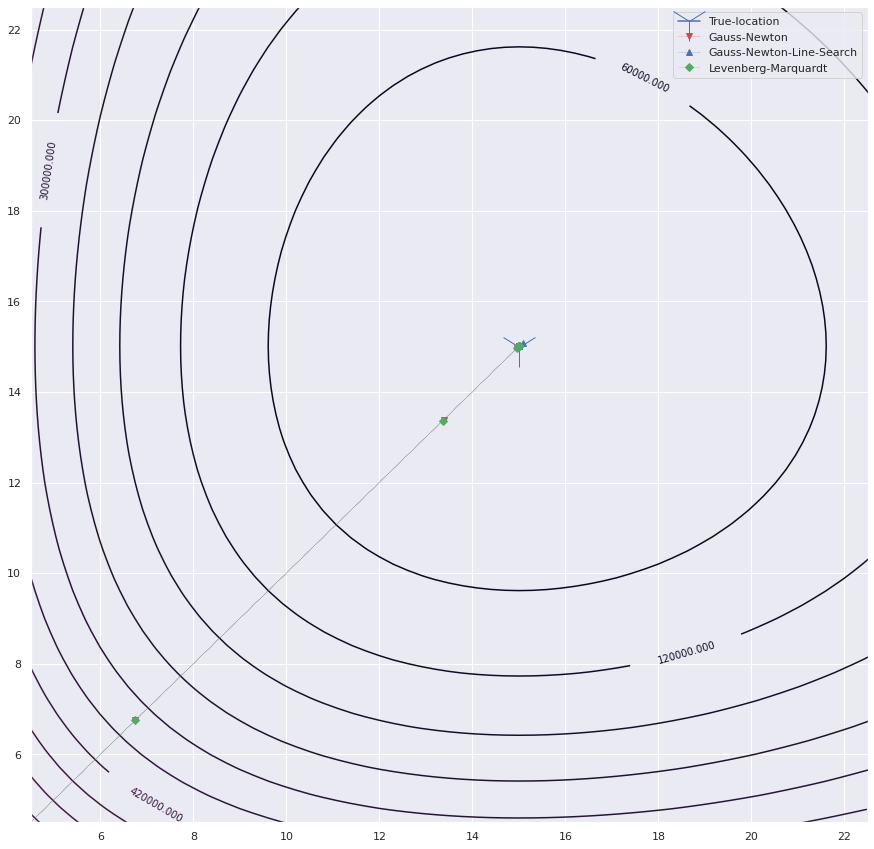

In [10]:
fig = plt.figure(figsize=(15,15))
point_size=6
ax = fig.add_subplot(111)
CS = ax.contour(x_grid,y_grid,J,levels=50)
ax.clabel(CS, inline=1, fontsize=10)
ax.plot(x[0],x[1],c='b',marker="1",markersize=40,label='True-location')
ax.plot(x_history_GN[:,0],x_history_GN[:,1],':r',marker='v',linewidth=0.5,label='Gauss-Newton')
ax.plot(x_history_GN_LS[:,0],x_history_GN_LS[:,1],':b',marker='^',linewidth=0.5,label='Gauss-Newton-Line-Search')
ax.plot(x_history_LM[:,0],x_history_LM[:,1],':g',marker='D',linewidth=0.5,label='Levenberg-Marquardt')
ax.legend()
ax.set_xlim(0.15*X_max,0.75*X_max)
ax.set_ylim(0.15*Y_max,0.75*Y_max)

Text(0.5, 1.0, 'Squarederror')

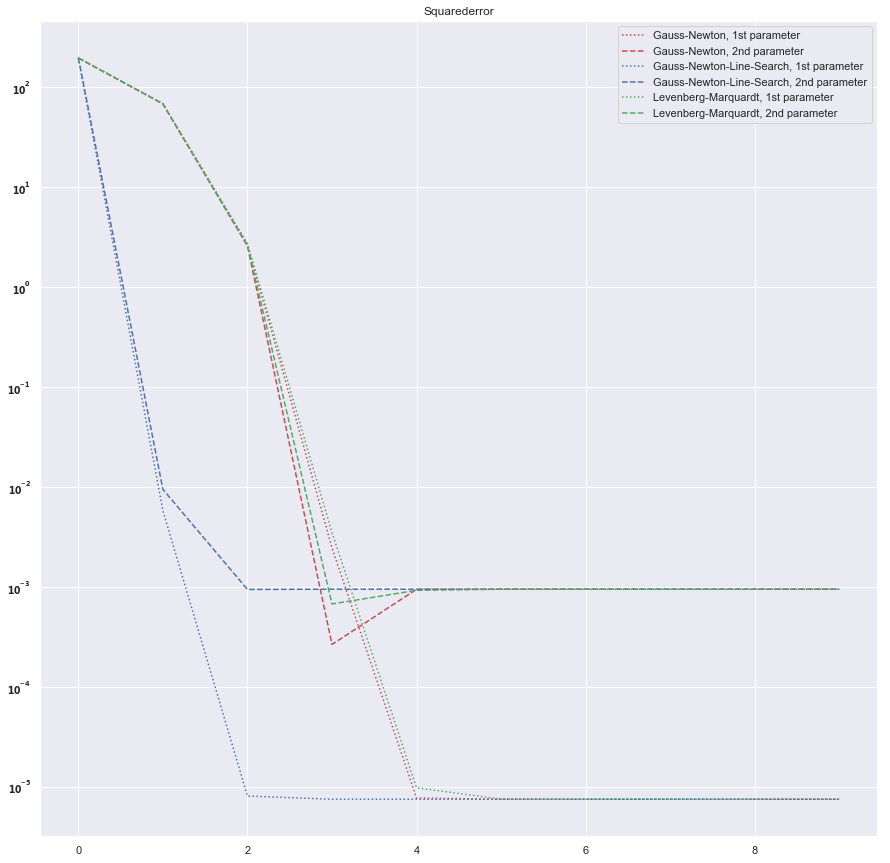

In [22]:
fig = plt.figure(figsize=(15,15))
plt.semilogy(np.square(x_history_GN[:,0]-x[0]),':r',label='Gauss-Newton, 1st parameter')
plt.semilogy(np.square(x_history_GN[:,1]-x[1]),'--r',label='Gauss-Newton, 2nd parameter')
plt.semilogy(np.square(x_history_GN_LS[:,0]-x[0]),':b',label='Gauss-Newton-Line-Search, 1st parameter')
plt.semilogy(np.square(x_history_GN_LS[:,1]-x[1]),'--b',label='Gauss-Newton-Line-Search, 2nd parameter')
plt.semilogy(np.square(x_history_LM[:,0]-x[0]),':g',label='Levenberg-Marquardt, 1st parameter')
plt.semilogy(np.square(x_history_LM[:,1]-x[1]),'--g',label='Levenberg-Marquardt, 2nd parameter')
plt.legend()
plt.title('Squarederror')